# Icevision DurAIn-ni (load model)

Install from pypi...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

--2022-09-04 08:40:59--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [text/plain]
Saving to: ‘icevision_install.sh.1’

icevision_install.s 100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-09-04 08:41:00 (52.3 MB/s) - ‘icevision_install.sh.1’ saved [2820/2820]



In [3]:
import subprocess
try: # เช็คว่ามี GPU รึเปล่า
    subprocess.check_output('nvidia-smi')
    print('มี GPU!')
    print('ทำการติดตั้งสำหรับ CUDA 11 เพื่อใช้งาน GPU')
    process = 'cuda11'    

except Exception: # ถ้าไม่มี
    print('ไม่มี GPU ลงเวอร์ชั่น CPU!')
    process = 'cpu'   

!bash icevision_install.sh {process} master #เรียกใช้งาน Script

มี GPU!
ทำการติดตั้งสำหรับ CUDA 11 เพื่อใช้งาน GPU
Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
- Installing mmcv
- Installing mmdet
- Installing mmseg
- Installing icevision from master
- Installing icedata from master
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
icevision installation finished!


In [9]:
from icevision.all import *

In [4]:
from icevision.models import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:18
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /root/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:20


In [10]:
from PIL import Image, ImageOps

In [11]:
#upload checkpoint path
checkpoint_path = '/content/drive/MyDrive/Leaf_model/Leaf_disease_62per_fastrcnn.pth'

In [19]:
# The model is automatically recreated in the evaluation mode. To unset that mode, you only need to pass `eval_mode=Fales`)
checkpoint_and_model = model_from_checkpoint(checkpoint_path, 
    model_name='mmdet.faster_rcnn', 
    backbone_name='resnet101_fpn_2x',
    img_size=512, 
    is_coco=False)

# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]

# Check device
device=next(model.parameters()).device
device

# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

def img_resize(input_path, output_path, img_size):
  desired_size = img_size
  im = Image.open(input_path)
  im = ImageOps.exif_transpose(im) # fix image rotating
  #im = im.convert('L') #Convert to gray
  old_size = im.size  # old_size[0] is in (width, height) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  # use thumbnail() or resize() method to resize the input image

  # thumbnail is a in-place operation

  # im.thumbnail(new_size, Image.ANTIALIAS)

  im = im.resize(new_size, Image.ANTIALIAS)
  # create a new image and paste the resized on it

  new_im = Image.new("RGB", (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2,
                      (desired_size-new_size[1])//2))

  #display(new_im)

  #Save resize image
  new_im.save(output_path)
  
  print("resize finished!!")


def get_img_detection(img_path):
   
  #Get_Idcard_detail(file_path=img_path)
  img = PIL.Image.open(img_path)
  img = ImageOps.exif_transpose(img) # fix image rotating

  try:
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  except ValueError:# if image size to small resize it!
    print(f"Image size  not support resizing...")
    img_resize(img_path,img_path,1280)
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
  
  return pred_dict['img']

def get_detection(img_path):
 
  #Get_Idcard_detail(file_path=img_path)
  img = PIL.Image.open(img_path)
  img = ImageOps.exif_transpose(img) # fix image rotating

  try:
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  except ValueError:# if image size to small resize it!
    print(f"Image size  not support resizing...")
    img_resize(img_path,img_path,1280)
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  try:
    labels, acc = pred_dict['detection']['labels'][0], pred_dict['detection']['scores'][0]
    acc = acc * 100
    print(f"Result : {labels} with {round(acc, 2)}% confidence.")
  except IndexError:
    print("No disease found! please take image again!")
    labels = "None"
    acc = 0

load checkpoint from local path: /content/drive/MyDrive/Leaf_model/Leaf_disease_62per_fastrcnn.pth


2022-09-04 08:49:53,642 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-09-04 08:49:53,646 - mmcv - INFO - load model from: torchvision://resnet101
2022-09-04 08:49:53,649 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
2022-09-04 08:49:53,858 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-09-04 08:49:53,911 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-09-04 08:49:53,940 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-09-04 08:49:53,948 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'layer': 'Linear', 'override': [{'

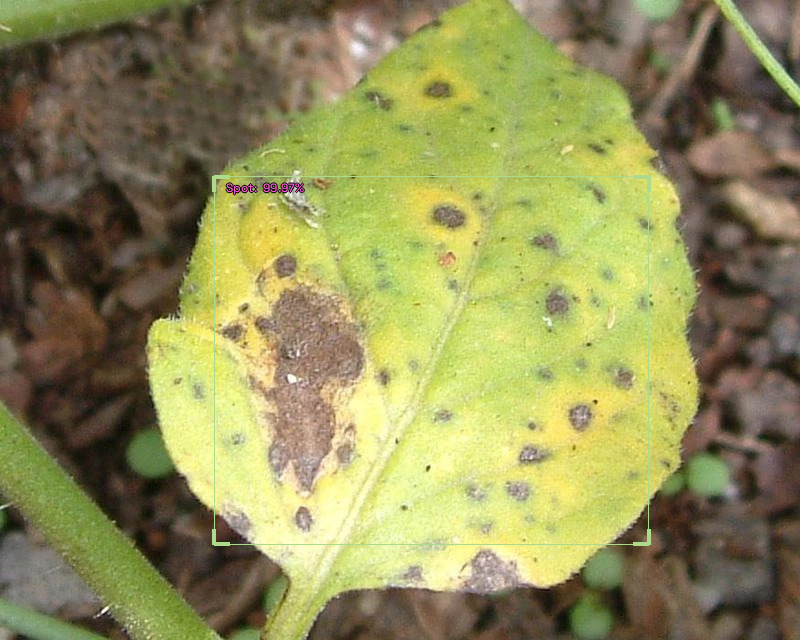

In [20]:
get_img_detection('/content/blight_leaf.jpeg')


In [21]:
get_detection('/content/blight_leaf.jpeg')

Result : spot with 99.97% confidence.


Test wrong img

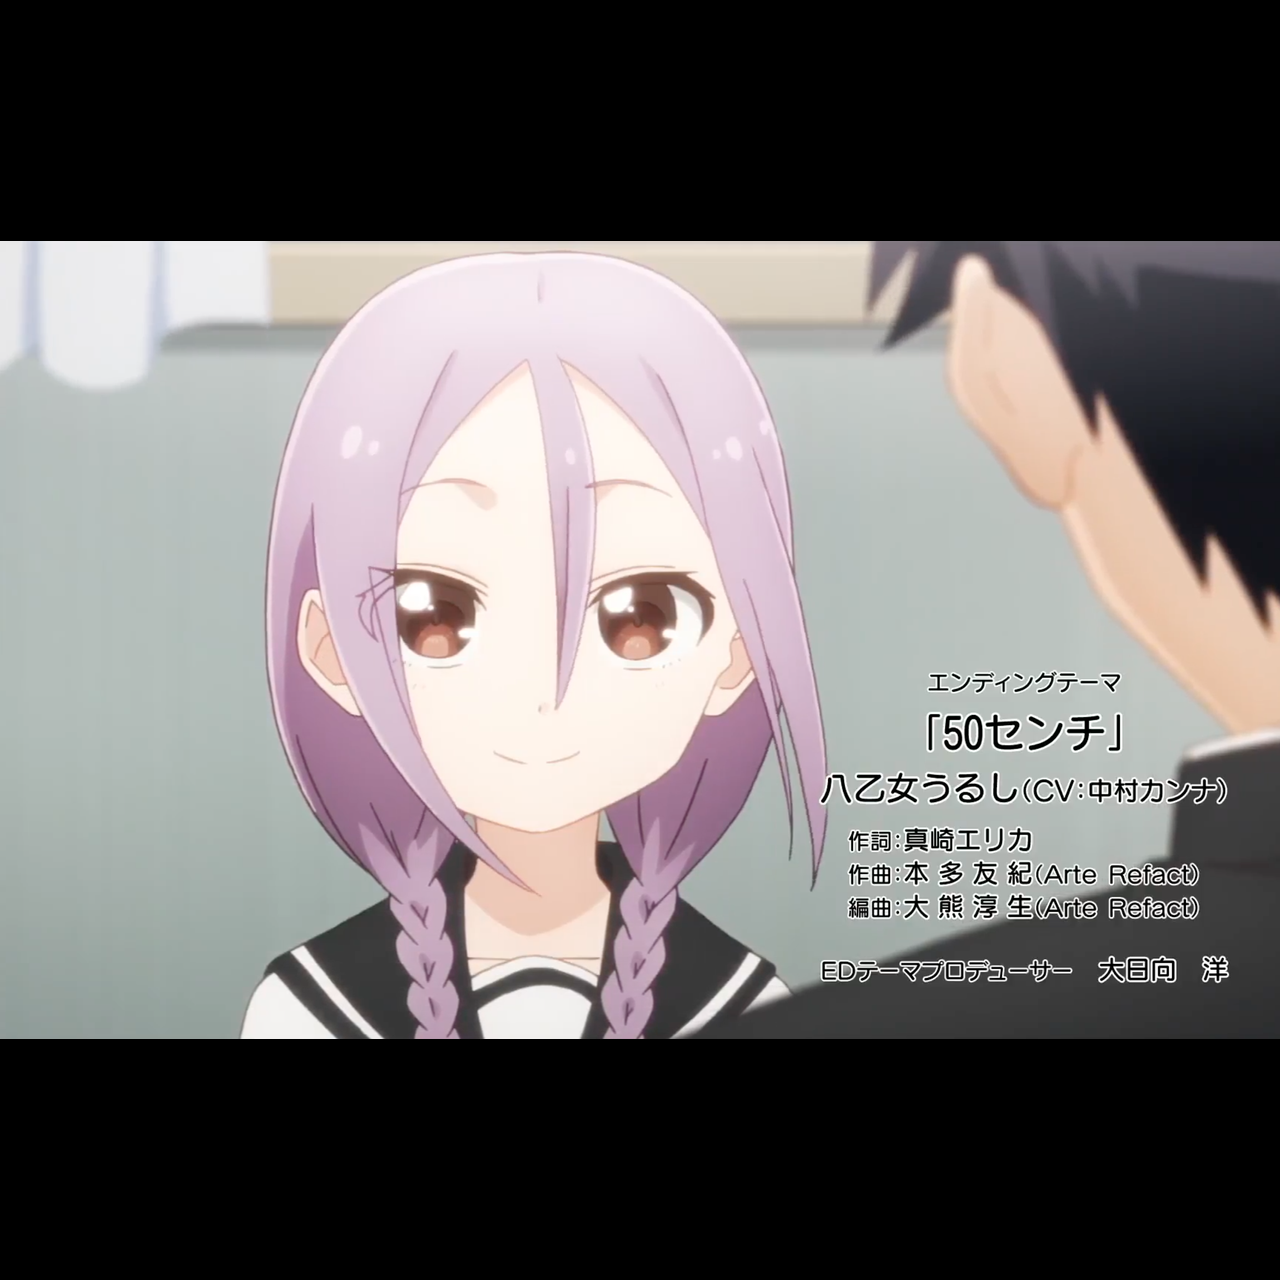

In [25]:
get_img_detection('/content/Senpaii.png')

In [26]:
get_detection('/content/Senpaii.png')

No disease found! please take image again!
